In [88]:
import os
import tarfile
import hashlib
import requests
import zipfile
#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [54]:
def download(name, cache_dir=os.path.join('..','data')): #@save
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB} "
    url, shal_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok= True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        shal = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                shal.hexdigest() == shal_hash
                return fname
    print(f'正在从{url}中下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [8]:
def download_extract(name, folder=None): #@save
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all(): #@save
    for name in DATA_HUB:
        download(name)

In [55]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [90]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [91]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [92]:
train_data.shape, test_data.shape

((1460, 81), (1459, 80))

In [93]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [94]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [95]:
#有一些数据缺失，可以根据均值或者标准差来确定， 需要注意的是不能是字符串
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

all_features[numeric_features] =all_features[numeric_features].apply(
    lambda x:(x-x.mean())/(x.std()))
#在标准化数据之后，将na设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [96]:

all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 330)

In [63]:
n_train = train_data.shape[0]
n_train

1460

In [65]:
train_features = torch.tensor(all_features[:n_train].values, dtype = torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [67]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net


In [68]:
help(torch.clamp)

Help on built-in function clamp in module torch:

clamp(...)
    clamp(input, min=None, max=None, *, out=None) -> Tensor
    
    Clamps all elements in :attr:`input` into the range `[` :attr:`min`, :attr:`max` `]`.
    Letting min_value and max_value be :attr:`min` and :attr:`max`, respectively, this returns:
    
    .. math::
        y_i = \min(\max(x_i, \text{min\_value}_i), \text{max\_value}_i)
    
    If :attr:`min` is ``None``, there is no lower bound.
    Or, if :attr:`max` is ``None`` there is no upper bound.
    
    
    .. note::
        If :attr:`min` is greater than :attr:`max` :func:`torch.clamp(..., min, max) <torch.clamp>`
        sets all elements in :attr:`input` to the value of :attr:`max`.
    
    Args:
        input (Tensor): the input tensor.
        min (Number or Tensor, optional): lower-bound of the range to be clamped to
        max (Number or Tensor, optional): upper-bound of the range to be clamped to
    
    Keyword args:
        out (Tensor, optional):

In [69]:
help(torch.linspace)

Help on built-in function linspace in module torch:

linspace(...)
    linspace(start, end, steps, *, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False) -> Tensor
    
    Creates a one-dimensional tensor of size :attr:`steps` whose values are evenly
    spaced from :attr:`start` to :attr:`end`, inclusive. That is, the value are:
    
    .. math::
        (\text{start},
        \text{start} + \frac{\text{end} - \text{start}}{\text{steps} - 1},
        \ldots,
        \text{start} + (\text{steps} - 2) * \frac{\text{end} - \text{start}}{\text{steps} - 1},
        \text{end})
    
    
    From PyTorch 1.11 linspace requires the steps argument. Use steps=100 to restore the previous behavior.
    
    Args:
        start (float or Tensor): the starting value for the set of points. If `Tensor`, it must be 0-dimensional
        end (float or Tensor): the ending value for the set of points. If `Tensor`, it must be 0-dimensional
        steps (int): size of the cons

In [71]:
def log_rmse(net, features, labels):
    #为了在取对数的进一步稳定数值，降小于1的数设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [81]:
def train(net, train_features, train_labels, test_features, test_labels, 
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(),lr = learning_rate, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls
            

In [79]:
def get_k_fold(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0]//k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j*fold_size, (j+1)*fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_vaild, y_vaild = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_vaild, y_vaild
            

In [75]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum+=train_ls[-1]
        valid_l_sum+=valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs+1)), [train_ls, valid_ls],
                     xlabel = 'epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')

        print(f'折{i+1}， 训练log rmse{float(train_ls[-1]):f}, ' f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1， 训练log rmse7.848918, 验证log rmse8.333160
折2， 训练log rmse7.734916, 验证log rmse8.183063
折3， 训练log rmse7.945172, 验证log rmse8.455582
折4， 训练log rmse7.912745, 验证log rmse8.497546
折5， 训练log rmse7.972333, 验证log rmse8.351192
 平均训练log rmse7.882817, 平均验证log rmse8.364108


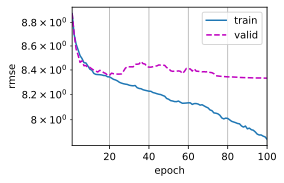

In [87]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f' 平均训练log rmse{float(train_l):f}, ' f'平均验证log rmse{float(valid_l):f}')